# Context Dependent Generalization
____
In this demonstration, we show that it is often beneficial to genearalize *skills* seperately from *goals*. In the following, simple artificial agents learn both how to navigate (a skill) and to find reward (a goal) across several highly similar tasks. Each task has a context, and if the agents use the context to generalize, they will see a performance benefit when the contexts are similar.

We present three agents. One agent (the "Flat" agent) does not generalize between context. A second (the "Joint Clustering" agent), clusters contexts as a whole, assuming that each member of a context cluster has the *exact* same statistics. The final (the "Independent Clustering" agent), clusters skills and goals seperately, assuming a paritial similiarity across contexts. 


### Description of the Agents
______

This Demonstration compares performance of reinforcement learning models across seperate seperate tasks. Each task consists of a series of trials with a single "goal" (a self-absorbing state with positive reward) hidden in a grid world. An agent is randomly place in the grid at the start of a trial and has to reach the goal before proceeding to the next trial.

* Each trial is associated with a *context* and the state of the agent can be defined formally as a tuple of its grid-coordinates and context:  
$$ s = (x, y, c)$$

* As this task models human behavior, we assume the agent knows the simple structure of the maze. We assume the agent knows cardinal directions, that is, "north" in one square is equivalent to "north" in another square. To navigate the maze, therefore, the agent has to learn the relationship between the primitive actions it can take and its own subsequent caridinal movements. There are eight primitive actions learning this relationship between actions and movements is a simple, generalizable "skill" that can potententially be transfered to new contexts efficaciously. Formally, these skills are a function that takes in an action and outputs a cardinal movement: 
$$ \phi: a \rightarrow m 
$$

* Independently of skill aquisition, the agents also learn a representation of goals in the form of a reward function, which is a mapping between states $s$ and rewards:
$$
R: s \rightarrow r $$

* The agents integrate over their skills and goals to plan. This is done with dynamic programming (policy iteration).
\br

The agents are different only in how they utalize the context:
* Flat Agent: Assumes each context is independent
* Joint Clustering Agent: Assumes contexts can be clustered together and clusters share both reward function and mapping
* Independent Clustering Agent: Assumes reward functions and mappings can be clustered indpendendly of each other based on their contexts

Cluster assignements are inferred with Bayesian inference. We assume all members of a cluster have the same statistics. For the joint model, this is both the skill and reward functions, while for the independent model it is either. These statistics, the learned skill and reward functions constitute the likelihood for Bayesian infernece.

For the prior, we assume a popularity-based generative process that lets the number of clusters grow with new contexts but prefers a small number of clusters. The degree to which the agents cluster depends on the parameter $\alpha$ that allows us to control the degree to which models cluster. Low alpha values corresponding to an increased tendency to cluster. High alpha values lead to less clustering and as alpha approaches infinity, both clustering collapse to the Flat model.

Formally, the prior over contexts is defined with a CRP where the probability that context *c* is in cluster *k* is defined:
$$\Pr\left (c_{n+1} = k| c_{1:n} \right ) = 
\begin{cases} 
N_k/A & \quad \text{if } k \leq K_n \\
\alpha/A & \quad \text{if } k = K_n+1 \\
\end{cases}
$$

where $N_k$ is the number of contexts associated with cluster $k$,  $K_n$ is the number of unique clusters associated with the $n$ observed contexts, and $A=\sum_{k}\left (N_k + \alpha \right )$ is a normalizing constant. As a consequence of this prior, clusters that have more associated contexts will have higher prior probability over new contexts.


In [1]:
%matplotlib inline
from model.agents import JointClustering, IndependentClusterAgent, FlatControlAgent
from model.gridworld import make_task
from model import list_entropy, mutual_information, plot_results
from model import simulate_mixed_task as simulate_task

# Task 1
The first set of simulations are on a set of 6x6 gridworlds. There are 4 contexts with
a total of 4 goal locations (one at each corner) and 2 skill sets (relationship between actions and movements). No two contexts share both a goal and a skill set, but generalization is still possible between them.

In [2]:
# define all of the task parameters
grid_world_size = (6, 6)

# define mapping between primitive action (a in [0, 1]) and cardinal movements
# (left, right, up down)
mapping_definitions = {
    0: {0: u'left', 1: u'up', 2: u'down', 3: u'right'},
    1: {4: u'up', 5: u'left', 6: u'right', 7: u'down'},
}

# define goal locations in (x, y) coordinate space
goal_locations = {
    0:(0, 0),
    1:(0, 5),
    2:(5, 0),
    3:(5, 5),
}


# assign goals and mappings to contexts
# context_goals = [0, 3, 0, 3, 0, 3, 0, 3]
# context_maps =  [0, 0, 1, 1, 0, 0, 1, 1]
context_goals = [0, 3, 0, 3]
context_maps =  [0, 0, 1, 1]


# randomly start the agent somewhere in the middle of the map
start_locations = [(x, y) for x in range(1, 5) for y in range(1, 5)]

# the number of times each context is shown
context_balance = [4] * len(context_goals)

# the hazard rate determines a degree of auto correlation in the context orders. This is
# useful in human studies. The hazard rates is the defined by the probability of a 
# context change after i repeats is f(i)
hazard_rates = [0.5, 0.67, 0.67, 0.75, 1.0, 1.0]


task_kwargs = dict(context_balance=context_balance, 
                   context_goals=[goal_locations[g] for g in context_goals], 
                   context_maps=[mapping_definitions[m] for m in context_maps],
                   hazard_rates=hazard_rates, start_locations=start_locations,
                   grid_world_size=grid_world_size,
                   )

In [3]:
print "Entropy H(G):   %.2f" % list_entropy(context_goals)
print "Entropy H(M):   %.2f" % list_entropy(context_maps)
print "Mutual Information I(G,M): %.2f" % mutual_information(context_goals, context_maps)

Entropy H(G):   1.00
Entropy H(M):   1.00
Mutual Information I(G,M): 0.00


Now, we simulate each model a couple hundred times (this can take a while) and plot the cumulative number of steps taken across 
trials. In the task, the agent must reach the goal (an absorbing state with positive reward)
to advance to the next trial. Lower cumulative steps taken indicated faster learning.

100%|██████████| 250/250 [13:30<00:00,  2.96s/it]


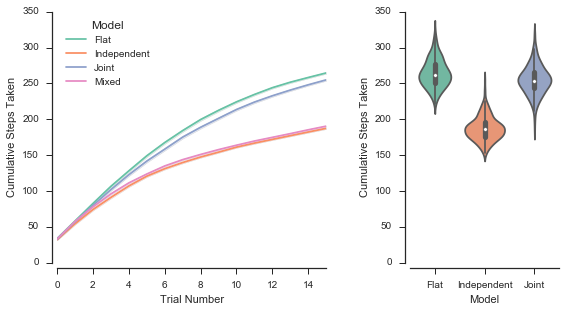

In [4]:
n_sim = 250
agent_kwargs = dict(discount_rate=0.75, inverse_temperature=10.0)
mix_kwargs = dict(mixing_lrate=0.1, mixing_temp=25.0, mix_bias=0.25)

sim1 = simulate_task(n_sim, task_kwargs, agent_kwargs=agent_kwargs, alpha=1.0, 
                     mix_kwargs=mix_kwargs)
        
plot_results(sim1, figsize=(9, 4.5))

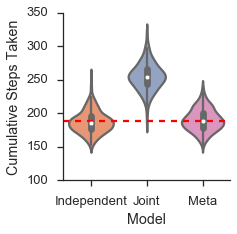

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df0 = sim1[sim1['In goal']].groupby(['Model', 'Simulation Number']).sum()
cum_steps = [df0.loc[m]['n actions taken'].values for m in set(sim1.Model)]
model = []
for m in set(sim1.Model):
    model += [m] * (sim1[sim1.Model == m]['Simulation Number'].max() + 1)
df1 = pd.DataFrame({
        'Cumulative Steps Taken': np.concatenate(cum_steps),
        'Model': model
    })

sns.set_context('talk')
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    cc = sns.color_palette('Set2')
    sns.violinplot(data=df1, x='Model', y='Cumulative Steps Taken', ax=ax, palette=cc[1:],
                   order=["Independent", "Joint", 'Mixed']
                   )
    ybar = df1.loc[df1.Model == 'Mixed', 'Cumulative Steps Taken'].median()
    ax.plot([-0.5, 3], [ybar, ybar], 'r--')
#     x_bar = 
#     ax.set_ylim(100, 200)
    ax.set_xticklabels(['Independent', 'Joint', 'Meta'])
    sns.despine()
    plt.savefig('sim1_mixed.png', dpi=300, bbox_inches='tight')

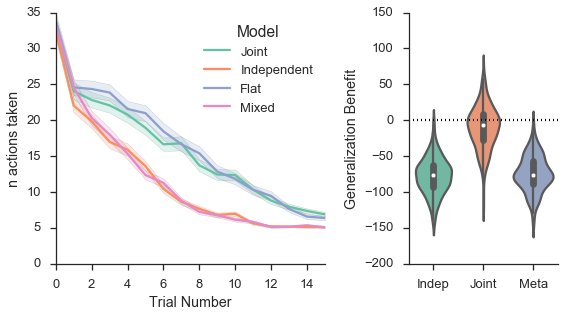

In [27]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

df0 = sim1[sim1['In goal']].groupby(['Model', 'Simulation Number']).sum()

flat = df0.loc['Flat']['n actions taken']
df1 = pd.DataFrame({
        'Meta': df0.loc['Mixed']['n actions taken']-flat,
        'Joint': df0.loc['Joint']['n actions taken']-flat,
        'Indep': df0.loc['Independent']['n actions taken']-flat
    })

with sns.axes_style('ticks'):
    _ = plt.figure(figsize=(9, 4.5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.8, 1], wspace=0.4)

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    
    sns.tsplot(time='Trial Number', value='n actions taken', data=sim1[sim1['In goal']],
          unit='Simulation Number', condition='Model', estimator=np.mean,
          color='Set2', ax=ax0)
    
    
    sns.violinplot(df1, palette='Set2', ax=ax1)
    ax1.plot(ax1.get_xlim(), [0, 0], 'k:')
    ax1.set_ylabel('Generalization Benefit')
    plt.legend()
    sns.despine()

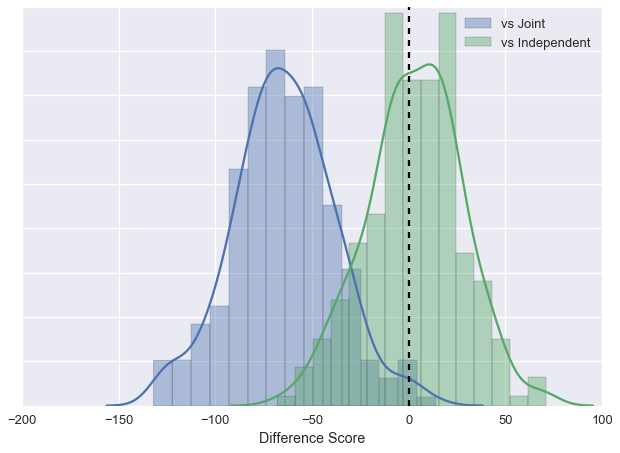

In [19]:
df1 = pd.DataFrame({
        'Mixed': df0.loc['Mixed']['n actions taken']-flat,
        'Joint': df0.loc['Joint']['n actions taken']-flat,
        'Indep': df0.loc['Independent']['n actions taken']-flat
    })
sns.distplot(df0.loc['Mixed']['n actions taken']-df0.loc['Joint']['n actions taken'],
             label='vs Joint')
sns.distplot(df0.loc['Mixed']['n actions taken']-df0.loc['Independent']['n actions taken'],
             label='vs Independent')
# sns.distplot(df1.Indep, label='Independent')
y_lims = plt.gca().get_ylim()
plt.gca().plot([0, 0], y_lims, 'k--')
plt.gca().set_ylim(y_lims)
plt.gca().set_xlabel('Difference Score')
plt.gca().set_yticklabels('')
plt.legend()

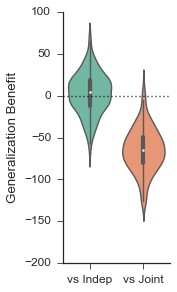

In [20]:
sns.set_context('paper', font_scale=1.5)
df1 = pd.DataFrame({
        'vs Indep': df0.loc['Mixed']['n actions taken']-df0.loc['Independent']['n actions taken'],
        'vs Joint': df0.loc['Mixed']['n actions taken']-df0.loc['Joint']['n actions taken'],
    })

with sns.axes_style('ticks'):
    _ = plt.figure(figsize=(3, 4.5))
    gs = gridspec.GridSpec(1, 1, width_ratios=[1.8, 1], wspace=0.4)

    ax0 = plt.subplot(gs[0])
#     ax1 = plt.subplot(gs[1])
    
#     sns.tsplot(time='Trial Number', value='n actions taken', data=sim2[sim2['In goal']],
#           unit='Simulation Number', condition='Model', estimator=np.mean,
#           color='Set2', ax=ax0)
    
    
    sns.violinplot(df1, palette='Set2', ax=ax0)
    ax0.plot(ax0.get_xlim(), [0, 0], 'k:')
    ax0.set_ylabel('Generalization Benefit')
    plt.legend()
    sns.despine()
    plt.savefig('Sim1_mix.png', dpi=300, bbox_inches='tight')

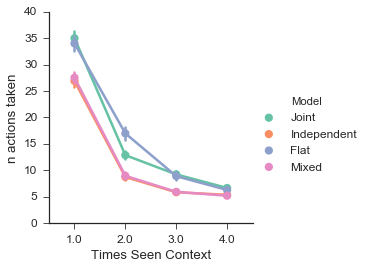

In [21]:
with sns.axes_style('ticks'):
    sns.factorplot(x='Times Seen Context', y='n actions taken', data=sim1[sim1['In goal']],
          units='Simulation Number', hue='Model', estimator=np.mean,
          palette='Set2')
    sns.despine()

We can see in this demonstration the agent that clusters reward functions and mappings between actions and movements independently is meaningfully faster that either agents that jointly cluster or agents that do not cluster.

## Task 2: Joint Clustering
Here, we show a task where it is useful to generalize contexts as a whole. Each context that shares a reward function with another context also shares its mapping between actions and movements. As such, generalizing the context as a whole is useful.

100%|██████████| 250/250 [3:42:04<00:00, 42.90s/it]


Entropy H(G):   2.00
Entropy H(M):   2.00
Mutual Information I(G,M): 2.00


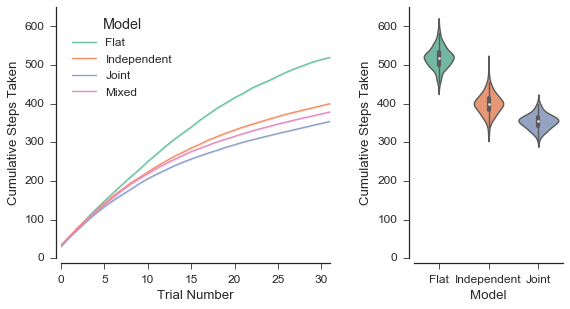

In [22]:
# define all of the task parameters
grid_world_size = (6, 6)

mapping_definitions = {
    0: {0: u'left', 1: u'up', 2: u'down', 3: u'right'},
    1: {4: u'up', 5: u'left', 6: u'right', 7: u'down'},
    2: {0: u'left', 1: u'up', 6: u'right', 7: u'down'},
    3: {4: u'up', 5: u'left', 2: u'down', 3: u'right'},
}

# define the mappings for each context, where the ith mapping belongs the ith context
context_goals = [0, 0, 1, 1, 2, 2, 3, 3]
context_maps =  [0, 0, 1, 1, 2, 2, 3, 3]

# define goal locations 
goal_locations = {
    0:(0, 0),
    1:(0, 5),
    2:(5, 0),
    3:(5, 5),
}

start_locations = [(x, y) for x in range(1, 5) for y in range(1, 5)]
context_balance = [4] * len(context_goals)


# randomly start the agent somewhere in the middle of the map
start_locations = [(1, 1)]
task_kwargs = dict(context_balance=context_balance, 
                   context_goals=[goal_locations[g] for g in context_goals], 
                   context_maps=[mapping_definitions[m] for m in context_maps],
                   hazard_rates=hazard_rates, start_locations=start_locations,
                   grid_world_size=grid_world_size
                  )

sim2 = simulate_task(n_sim, task_kwargs, agent_kwargs=agent_kwargs, 
                     alpha=1.0, mix_kwargs=mix_kwargs)


print "Entropy H(G):   %.2f" % list_entropy(context_goals)
print "Entropy H(M):   %.2f" % list_entropy(context_maps)
print "Mutual Information I(G,M): %.2f" % mutual_information(context_goals, context_maps)

plot_results(sim2, figsize=(9, 4.5))

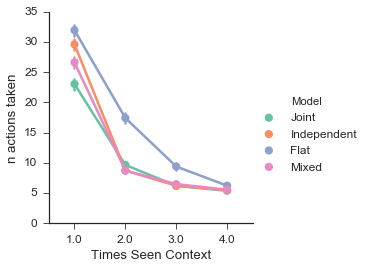

In [23]:
with sns.axes_style('ticks'):
    sns.factorplot(x='Times Seen Context', y='n actions taken', data=sim2[sim2['In goal']],
          units='Simulation Number', hue='Model', estimator=np.mean,
          palette='Set2')
    sns.despine()

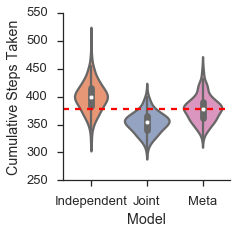

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df0 = sim2[sim2['In goal']].groupby(['Model', 'Simulation Number']).sum()
cum_steps = [df0.loc[m]['n actions taken'].values for m in set(sim2.Model)]
model = []
for m in set(sim2.Model):
    model += [m] * (sim2[sim2.Model == m]['Simulation Number'].max() + 1)
df1 = pd.DataFrame({
        'Cumulative Steps Taken': np.concatenate(cum_steps),
        'Model': model
    })

sns.set_context('talk')
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    cc = sns.color_palette('Set2')
    sns.violinplot(data=df1, x='Model', y='Cumulative Steps Taken', ax=ax, palette=cc[1:],
                   order=["Independent", "Joint", 'Mixed']
                   )
    ybar = df1.loc[df1.Model == 'Mixed', 'Cumulative Steps Taken'].median()
    ax.plot([-0.5, 3], [ybar, ybar], 'r--')
#     x_bar = 
#     ax.set_ylim(100, 200)
    ax.set_xticklabels(['Independent', 'Joint', 'Meta'])

    sns.despine()
    plt.savefig('sim2_mixed.png', dpi=300, bbox_inches='tight')

/Users/nickfranklin/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/Users/nickfranklin/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


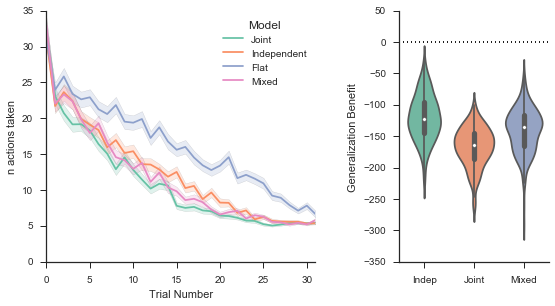

In [10]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

df0 = sim2[sim2['In goal']].groupby(['Model', 'Simulation Number']).sum()

flat = df0.loc['Flat']['n actions taken']
df1 = pd.DataFrame({
        'Mixed': df0.loc['Mixed']['n actions taken']-flat,
        'Joint': df0.loc['Joint']['n actions taken']-flat,
        'Indep': df0.loc['Independent']['n actions taken']-flat
    })

with sns.axes_style('ticks'):
    _ = plt.figure(figsize=(9, 4.5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.8, 1], wspace=0.4)

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    
    sns.tsplot(time='Trial Number', value='n actions taken', data=sim2[sim2['In goal']],
          unit='Simulation Number', condition='Model', estimator=np.mean,
          color='Set2', ax=ax0)
    
    
    sns.violinplot(df1, palette='Set2', ax=ax1)
    ax1.plot(ax1.get_xlim(), [0, 0], 'k:')
    ax1.set_ylabel('Generalization Benefit')
    plt.legend()
    sns.despine()

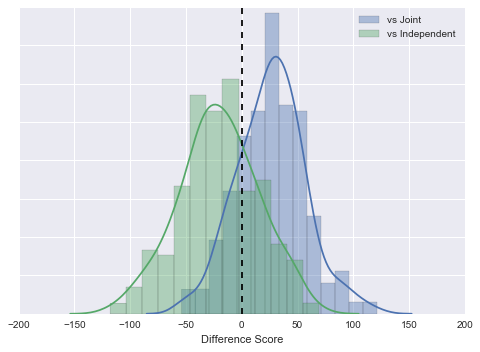

In [11]:
df1 = pd.DataFrame({
        'Mixed': df0.loc['Mixed']['n actions taken']-flat,
        'Joint': df0.loc['Joint']['n actions taken']-flat,
        'Indep': df0.loc['Independent']['n actions taken']-flat
    })
sns.distplot(df0.loc['Mixed']['n actions taken']-df0.loc['Joint']['n actions taken'],
             label='vs Joint')
sns.distplot(df0.loc['Mixed']['n actions taken']-df0.loc['Independent']['n actions taken'],
             label='vs Independent', )
# sns.distplot(df1.Indep, label='Independent')
y_lims = plt.gca().get_ylim()
plt.gca().plot([0, 0], y_lims, 'k--')
plt.gca().set_ylim(y_lims)
plt.gca().set_xlabel('Difference Score')
plt.gca().set_yticklabels('')
plt.legend()

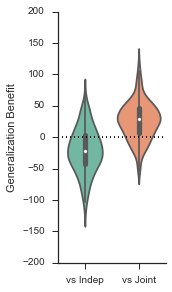

In [12]:
df1 = pd.DataFrame({
        'vs Indep': df0.loc['Mixed']['n actions taken']-df0.loc['Independent']['n actions taken'],
        'vs Joint': df0.loc['Mixed']['n actions taken']-df0.loc['Joint']['n actions taken'],
    })

with sns.axes_style('ticks'):
    _ = plt.figure(figsize=(3, 4.5))
    gs = gridspec.GridSpec(1, 1, width_ratios=[1.8, 1], wspace=0.4)

    ax0 = plt.subplot(gs[0])
#     ax1 = plt.subplot(gs[1])
    
#     sns.tsplot(time='Trial Number', value='n actions taken', data=sim2[sim2['In goal']],
#           unit='Simulation Number', condition='Model', estimator=np.mean,
#           color='Set2', ax=ax0)
    
    
    sns.violinplot(df1, palette='Set2', ax=ax0)
    ax0.plot(ax0.get_xlim(), [0, 0], 'k:')
    ax0.set_ylabel('Generalization Benefit')
    plt.legend()
    sns.despine()
    plt.savefig('Sim2_mix.png', dpi=300, bbox_inches='tight')

Here, we can see that clustering the reward functions and mappings together outperforms the flat agent. We can also construct enviornments in which there is a substantial benefit to this type of generalization. However, independently clustering provides a more flexable method that does not suffer the same performance penalties as the joint clustering. 

Notice that this also depends on parameterization. Here, it useful for have a lower value of alpha as the number of useful clusters is much lower than the number of contexts.

In [32]:
vec = sim2[sim2['Steps in Context']<100].groupby(['Model', 'Simulation Number', 'Steps in Context']).mean()['KL Mapping']
vec = vec.reset_index()
vec = pd.concat([vec[vec['Model']=='Joint'], vec[vec['Model']=='Independent'], 
                vec[vec['Model']=='Flat']])

sns.set_context('paper', font_scale=1.5)
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(1, 2, figsize=(6, 2.5), sharey=False)
    sns.pointplot(data=sim2, x='Times Seen Context', 
               y='KL Rewards', hue='Model', ax=axes[0], palette=sns.color_palette('Set2'),
                 )
    
    
    vec.loc[vec.Model == 'Independent Clustering', 'Model'] = "Ind."
    vec.loc[vec.Model == 'Joint Clustering', 'Model'] = "Joint"
    vec.loc[vec.Model == 'Flat Agent', 'Model'] = "Flat"
    sns.tsplot(data=vec, time='Steps in Context', unit='Simulation Number',
               value='KL Mapping', condition='Model', ax=axes[1], color=sns.color_palette('Set2'),
               ci=95)
    sns.despine(offset=5)
    
    axes[0].set_xticklabels([1, 2, 3, 4])
    axes[0].set_ylabel('KL Divergence')
    axes[1].set_ylim([0, 14])
    axes[1].set_ylabel('')
    axes[0].set_title('Rewards')
    axes[1].set_title('Mappings')
    axes[1].set_xlim([0, 40])
    
    axes[0].legend_.remove()
    axes[1].legend(loc='upper right')
        
    plt.subplots_adjust(hspace=0.5)

KeyError: 'KL Mapping'

100%|██████████| 250/250 [10:32<00:00,  2.51s/it]


Entropy H(G):   1.00
Entropy H(M):   1.00
Mutual Information I(G,M): 1.00


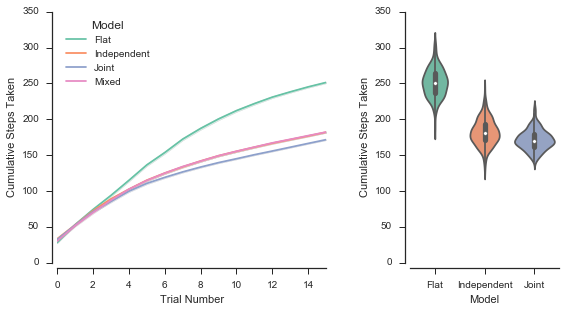

In [13]:
# define all of the task parameters
grid_world_size = (6, 6)

mapping_definitions = {
    0: {0: u'left', 1: u'up', 2: u'down', 3: u'right'},
    1: {4: u'up', 5: u'left', 6: u'right', 7: u'down'},
    2: {0: u'left', 1: u'up', 6: u'right', 7: u'down'},
    3: {4: u'up', 5: u'left', 2: u'down', 3: u'right'},
}

# define the mappings for each context, where the ith mapping belongs the ith context
context_goals = [0, 0, 3, 3]
context_maps =  [0, 0, 1, 1]

# define goal locations 
goal_locations = {
    0:(0, 0),
    1:(0, 5),
    2:(5, 0),
    3:(5, 5),
}

start_locations = [(x, y) for x in range(1, 5) for y in range(1, 5)]
context_balance = [4] * len(context_goals)


# randomly start the agent somewhere in the middle of the map
start_locations = [(1, 1)]
task_kwargs = dict(context_balance=context_balance, 
                   context_goals=[goal_locations[g] for g in context_goals], 
                   context_maps=[mapping_definitions[m] for m in context_maps],
                   hazard_rates=hazard_rates, start_locations=start_locations,
                   grid_world_size=grid_world_size
                  )

sim3 = simulate_task(n_sim, task_kwargs, agent_kwargs=agent_kwargs, 
                     alpha=1.0, mix_kwargs=mix_kwargs)


print "Entropy H(G):   %.2f" % list_entropy(context_goals)
print "Entropy H(M):   %.2f" % list_entropy(context_maps)
print "Mutual Information I(G,M): %.2f" % mutual_information(context_goals, context_maps)

plot_results(sim3, figsize=(9, 4.5))

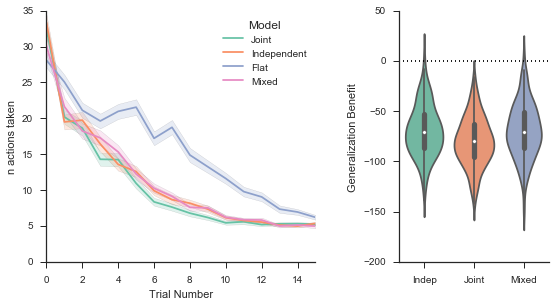

In [15]:
df0 = sim3[sim3['In goal']].groupby(['Model', 'Simulation Number']).sum()

flat = df0.loc['Flat']['n actions taken']
df1 = pd.DataFrame({
        'Mixed': df0.loc['Mixed']['n actions taken']-flat,
        'Joint': df0.loc['Joint']['n actions taken']-flat,
        'Indep': df0.loc['Independent']['n actions taken']-flat
    })

with sns.axes_style('ticks'):
    _ = plt.figure(figsize=(9, 4.5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.8, 1], wspace=0.4)

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    
    sns.tsplot(time='Trial Number', value='n actions taken', data=sim3[sim3['In goal']],
          unit='Simulation Number', condition='Model', estimator=np.mean,
          color='Set2', ax=ax0)
    
    
    sns.violinplot(df1, palette='Set2', ax=ax1)
    ax1.plot(ax1.get_xlim(), [0, 0], 'k:')
    ax1.set_ylabel('Generalization Benefit')
    plt.legend()
    sns.despine()